In [1]:
import pickle
import pandas as pd
import numpy as np

# Load NBM percentile tables
with open('distributions/percentile_tables_NBM.pkl', 'rb') as f:
    percentile_tables_NBM = pickle.load(f)

# Load NAM percentile tables  
with open('distributions/percentile_tables_NAM.pkl', 'rb') as f:
    percentile_tables_NAM = pickle.load(f)

print("=" * 60)
print("99th PERCENTILE BPS VALUES FROM HISTORICAL DATA")
print("=" * 60)

print("\nNBM (New Breakout Move) - 99th Percentile Dips:")
print("-" * 50)
for breakeven in [2, 3, 4, 5]:
    if breakeven in percentile_tables_NBM:
        p99_value = percentile_tables_NBM[breakeven]['stats']['p99']
        count = percentile_tables_NBM[breakeven]['stats']['count']
        mean = percentile_tables_NBM[breakeven]['stats']['mean']
        print(f"Breakeven {breakeven} bps: {p99_value:.2f} bps (count: {count:,}, mean: {mean:.2f})")
    else:
        print(f"Breakeven {breakeven} bps: No data available")

print("\nNAM (New Advance Move) - 99th Percentile Rises:")
print("-" * 50)
for breakeven in [1, 1.5, 2, 2.5, 3, 4, 5]:
    if breakeven in percentile_tables_NAM:
        p99_value = percentile_tables_NAM[breakeven]['stats']['p99']
        count = percentile_tables_NAM[breakeven]['stats']['count']
        mean = percentile_tables_NAM[breakeven]['stats']['mean']
        print(f"Breakeven {breakeven} bps: {p99_value:.2f} bps (count: {count:,}, mean: {mean:.2f})")
    else:
        print(f"Breakeven {breakeven} bps: No data available")

print("\n" + "=" * 60)
print("SUMMARY TABLE")
print("=" * 60)

# Create summary DataFrame
summary_data = []
for breakeven in [1, 1.5, 2, 2.5, 3, 4, 5]:
    nbm_p99 = percentile_tables_NBM[breakeven]['stats']['p99'] if breakeven in percentile_tables_NBM else np.nan
    nam_p99 = percentile_tables_NAM[breakeven]['stats']['p99'] if breakeven in percentile_tables_NAM else np.nan
    
    summary_data.append({
        'Breakeven (bps)': breakeven,
        'NBM 99th Percentile (bps)': nbm_p99,
        'NAM 99th Percentile (bps)': nam_p99
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False, float_format='%.2f'))

# Store the 99th percentile values for easy access
NBM_99th = {}
NAM_99th = {}

for breakeven in [2, 3, 4, 5]:
    if breakeven in percentile_tables_NBM:
        NBM_99th[breakeven] = percentile_tables_NBM[breakeven]['stats']['p99']
    if breakeven in percentile_tables_NAM:
        NAM_99th[breakeven] = percentile_tables_NAM[breakeven]['stats']['p99']

print(f"\nNBM 99th percentile values stored in: NBM_99th = {NBM_99th}")
print(f"NAM 99th percentile values stored in: NAM_99th = {NAM_99th}")


FileNotFoundError: [Errno 2] No such file or directory: 'distributions/percentile_tables_NBM.pkl'

In [2]:
import pickle

# Specify the path to your pickle file
file_path = 'C:/Users/YamanSanghavi/Desktop/NAM_NBM_Final_Code/distributions/percentile_tables_NAM.pkl'

# Open the pickle file in read-binary mode
with open(file_path, 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)

# Now you can use the data
print(data)

{2: {'rises': array([ 6.  ,  6.25,  6.25,  6.25,  6.25,  6.5 ,  6.5 ,  6.75,  6.75,
        6.75,  7.  ,  7.  ,  7.25,  7.25,  7.25,  7.5 ,  7.5 ,  7.5 ,
        7.5 ,  7.5 ,  7.75,  7.75,  7.75,  7.75,  7.75,  8.  ,  8.  ,
        8.  ,  8.  ,  8.75,  9.  ,  9.  ,  9.  ,  9.25,  9.5 ,  9.5 ,
        9.5 , 10.25, 10.25, 10.25, 10.75, 11.  , 11.25, 11.25, 11.5 ,
       11.75, 12.  , 12.  , 12.5 , 13.  , 14.  , 14.5 , 14.75, 15.75,
       16.75, 16.75, 19.75, 20.  , 21.  , 25.5 ]), 'percentiles': array([  0.        ,   1.69491525,   3.38983051,   5.08474576,
         6.77966102,   8.47457627,  10.16949153,  11.86440678,
        13.55932203,  15.25423729,  16.94915254,  18.6440678 ,
        20.33898305,  22.03389831,  23.72881356,  25.42372881,
        27.11864407,  28.81355932,  30.50847458,  32.20338983,
        33.89830508,  35.59322034,  37.28813559,  38.98305085,
        40.6779661 ,  42.37288136,  44.06779661,  45.76271186,
        47.45762712,  49.15254237,  50.84745763,  52.542372

In [ ]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from shared_functions import preprocess_data, find_minimal_intervals
import matplotlib.pyplot as plt

# This is the live monitor that will be used to monitor the market dip in real-time.
# First we will load the price data till now.
# Then we will load the percentile tables.
# Then we define a function that will take the price data till now and give you the amoung of dip that has happened.
# Then we will use the percentile tables to give you the percentile of the dip that has happened.
# That's it.
# Let's make a function that will take the price data till now and give you the amount of dip that has happened.

def find_dip(df, breakeven_decimal, max_rise, threshold_for_NBM=6):

    # 1) Compute the "body" series and its cumulative sum (in decimal price units)
    delta_close = df["Close"].values - df["Close"].shift(1).values   
    df = df.iloc[1:]    
    if len(df) < 3:
        return np.nan
    #print(df.head())
    current_price = df["Close"].iloc[-1]

    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df = df.set_index('timestamp')  
    index_list = df.index  # DatetimeIndex, sorted ascending

    i_prev = len(df) - 1

    max_drop_for_t = -float('inf')
    aborted_due_to_nan = False

    # Walk backward from row i_prev down to row 0 (inclusive)
    for j in range(i_prev, -1, -1):

        row_j = df.iloc[j]

        # If any of OHLCV is NaN at row j, abort and record NaN for this t
        # This means we encountered an event time.
        if row_j[["Open", "High", "Low", "Close"]].isna().any():
            aborted_due_to_nan = True
            break
        
        # Compute drop_j = C_{t-1} - C_j  (sum of bodies from j+1 through i_prev)
        drop_j = -1*float(delta_close[j:i_prev+1].sum())
        
        if drop_j > max_drop_for_t:
            max_drop_for_t = drop_j
            max_drop_j = j
            max_drop_price = df["Open"].iloc[j]

        # Stop early if we've reached the threshold (≥ 0.1875 decimal)
        if max_drop_for_t - drop_j >= max_rise:
            break
        
    if aborted_due_to_nan:
        #print("Event time encountered.")
        return np.nan

    else:
        anchor_point = max_drop_price
        dip_length = anchor_point - current_price
        dip_bps = dip_length * 16
        #print(f"-----Anchor point: {anchor_point:.4f}")
        return dip_bps, anchor_point



def load_percentile_tables():
    """Load the percentile lookup tables created by historical_analysis.py"""
    with open('distributions/percentile_tables.pkl', 'rb') as f:
        return pickle.load(f)

def lookup_dip_percentile(dip_bps, percentile_tables, breakeven_decimal):
    """Look up what percentile the current dip represents"""
    
    # Historical tables are keyed by tick counts (e.g., 3, 4, 5) whereas here we receive
    # the decimal value (3/16 = 0.1875). Convert to ticks so we can locate the correct entry.
    breakeven_ticks = int(round(breakeven_decimal * 16))

    if breakeven_ticks not in percentile_tables:
        print(f"No historical data found for breakeven ticks = {breakeven_ticks}")
        return None

    table = percentile_tables[breakeven_ticks]
    sorted_dips = table['dips']
    percentiles = table['percentiles']
    
    # Find where current dip fits in historical distribution
    insert_idx = np.searchsorted(sorted_dips, dip_bps)
    
    if insert_idx == 0:
        return 0.0  # Smaller than any historical dip
    elif insert_idx >= len(percentiles):
        return 100.0  # Larger than any historical dip
    else:
        return percentiles[insert_idx]  # Interpolated percentile


# Example usage:
def main():
    # Load historical percentile tables
    percentile_tables = load_percentile_tables()
    
    df = pd.read_csv("CPI_Day.csv")
    df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_convert('US/Eastern').dt.tz_localize(None)
    df.rename(columns={'time': 'timestamp'}, inplace=True)
    df = df.rename(columns={'close': 'Close', 'open': 'Open', 'high': 'High', 'low': 'Low'})

    df = df[df['timestamp'] <= '2025-07-15 05:00:00']
    # Define breakeven threshold
    breakeven_decimal = 3/16
    # Calculate current dip
    result = find_dip(df, breakeven_decimal, breakeven_decimal)  # Use variable defined above

    if isinstance(result, tuple):  # Check if we got a valid result
        dip_bps, anchor_point = result
        # Find percentile of this dip
        percentile = lookup_dip_percentile(dip_bps, percentile_tables, breakeven_decimal)
        print(f"Current dip: {dip_bps:.2f} bps")
        print(f"Anchor point: {anchor_point:.4f}")  
        if percentile is None:
            print("Percentile could not be determined (no matching historical data).")
        else:
            print(f"Percentile: {percentile:.1f}%")
            # Your trading logic based on percentile goes here
            if percentile >= 90:
                print("Large dip detected - consider significant position")
            elif percentile >= 70:
                print("Moderate dip - consider small position")
            else:
                print("Small dip - wait for better opportunity")
    else:
        print("Could not calculate dip (NaN result)")


Breakeven = 3 bps
Number of data points: 1399


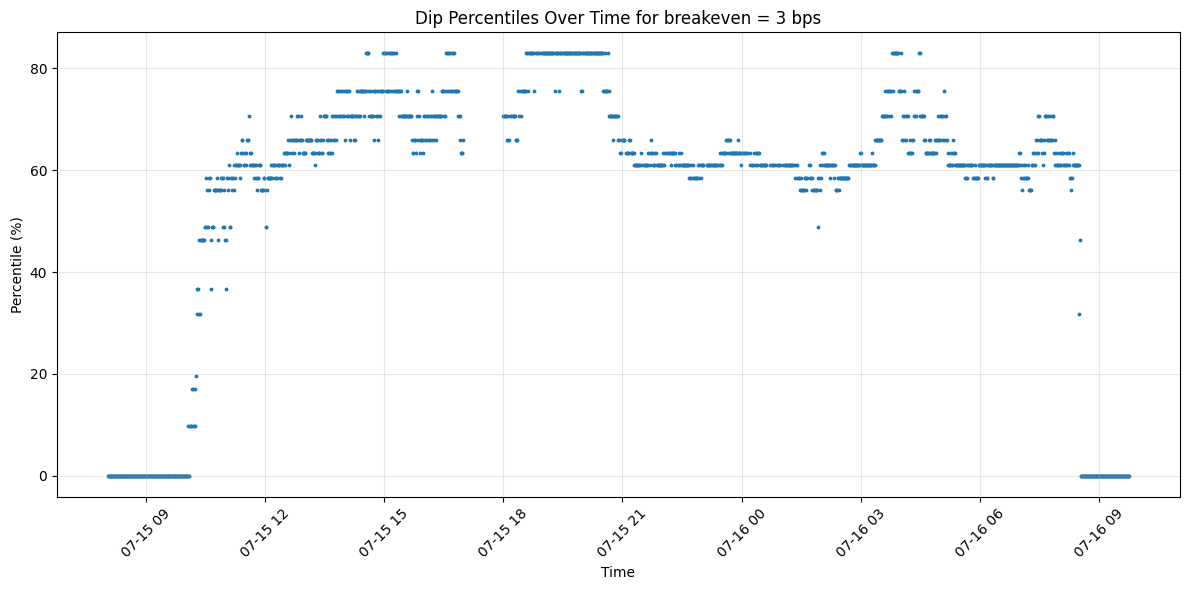

Breakeven = 4 bps
Number of data points: 1399


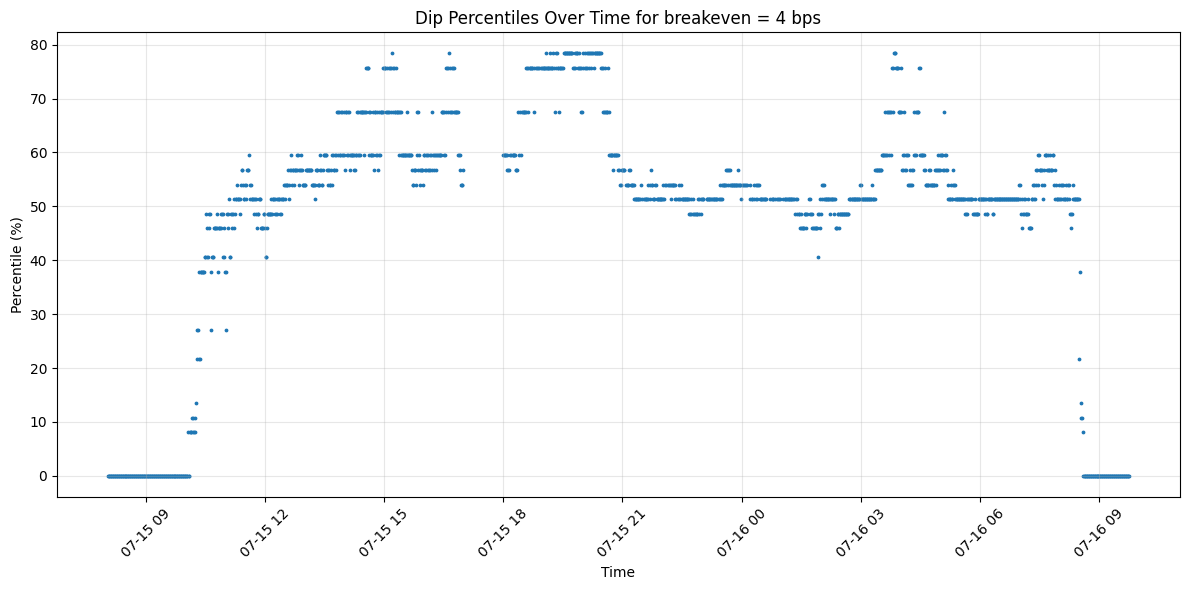

In [4]:
percentile_tables = load_percentile_tables()
df = pd.read_csv("CPI_Day.csv")
df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_convert('US/Eastern').dt.tz_localize(None)
df.rename(columns={'time': 'timestamp'}, inplace=True)
df = df.rename(columns={'close': 'Close', 'open': 'Open', 'high': 'High', 'low': 'Low'})
df = df[(df['timestamp'] >= '2025-07-15 08:00:00')]

for breakeven_decimal in [3/16, 4/16]:
    dip_list = []
    percentile_list = []
    time_list = []
    dip_dict = {}
    percentile_dict = {}
    time_dict = {}
    print(f"Breakeven = {int(breakeven_decimal*16)} bps")
    for i in range(len(df)-1, 0, -1):
        df2 = df.iloc[:i].copy()
        result = find_dip(df2, breakeven_decimal, breakeven_decimal)
        if isinstance(result, tuple):
            dip_list.append(result[0])
            percentile = lookup_dip_percentile(result[0], percentile_tables, breakeven_decimal)
            # Convert None to np.nan for consistency
            if percentile is None:
                percentile = np.nan
            percentile_list.append(percentile)
            #print(df2['timestamp'].iloc[i-1] , result[0], percentile, "%")
            time_list.append(df2['timestamp'].iloc[i-1])
        else:
            dip_list.append(np.nan)
            percentile_list.append(np.nan)
            time_list.append(np.nan)
    print(f"Number of data points: {len(time_list)}")
    # Filter out invalid values for plotting
    valid_indices = []
    for i, (time, percentile) in enumerate(zip(time_list, percentile_list)):
        if time is not None and not pd.isna(time) and percentile is not None and not pd.isna(percentile):
            valid_indices.append(i)
    
    if valid_indices:
        valid_times = [time_list[i] for i in valid_indices]
        valid_percentiles = [percentile_list[i] for i in valid_indices]

        percentile_dict[breakeven_decimal] = valid_percentiles
        time_dict[breakeven_decimal] = valid_times

        # Plot the percentile list with timestamps on the x-axis and percentiles on the y-axis
        plt.figure(figsize=(12, 6))
        plt.scatter(valid_times, valid_percentiles, marker='o', s=3)
        plt.xlabel('Time')
        plt.ylabel('Percentile (%)')
        plt.title(f'Dip Percentiles Over Time for breakeven = {int(breakeven_decimal*16)} bps')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save the plot with breakeven-specific filename
        filename = f'dip_percentiles_breakeven_{int(breakeven_decimal*16)}bps.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No valid data points to plot")



No data found for breakeven = 3 bps


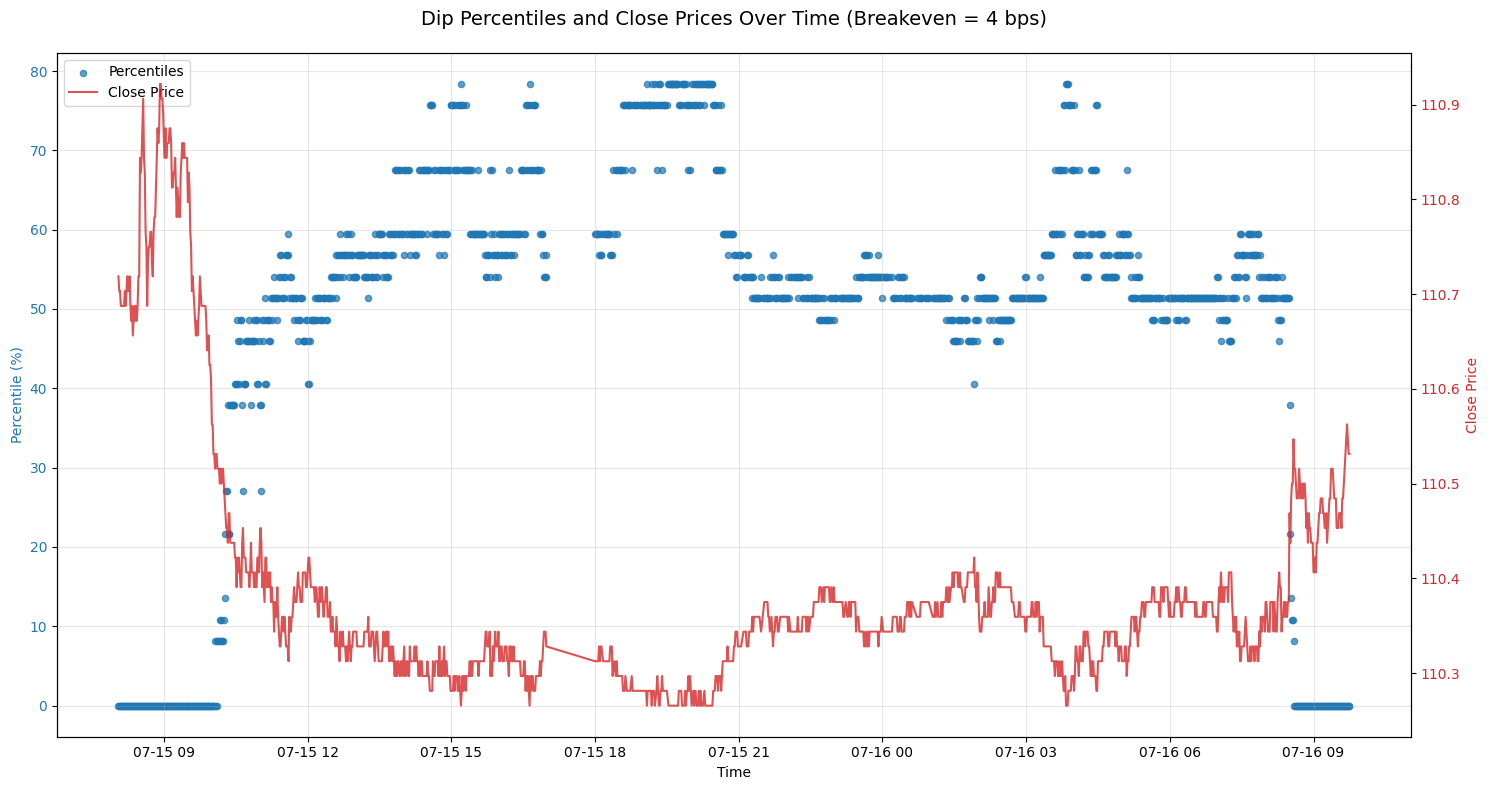

Plot saved as dip_percentiles_and_prices_breakeven_4bps.png


In [6]:
# Plot percentiles and Close prices for both breakeven values
# Initialize dictionaries if they don't exist
if 'time_list' not in locals():
    time_list = {}
if 'percentile_list' not in locals():
    percentile_list = {}

for breakeven_decimal in [3/16, 4/16]:
    # Check if data exists for this breakeven value
    try:
        times = time_dict[breakeven_decimal]
        percentiles = percentile_dict[breakeven_decimal]
        
        # Get Close prices at corresponding timestamps
        close_prices = []
        for timestamp in times:
            # Find the closest timestamp in df using pandas operations
            time_diff = (df['timestamp'] - timestamp).abs()
            closest_idx = time_diff.idxmin()
            close_prices.append(df.loc[closest_idx, 'Close'])
        
        # Create figure with dual y-axes
        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        # Plot percentiles on left y-axis
        color = 'tab:blue'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Percentile (%)', color=color)
        ax1.scatter(times, percentiles, color=color, marker='o', s=20, alpha=0.7, label='Percentiles')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, alpha=0.3)
        
        # Create second y-axis for Close prices
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Close Price', color=color)
        ax2.plot(times, close_prices, color=color, linewidth=1.5, alpha=0.8, label='Close Price')
        ax2.tick_params(axis='y', labelcolor=color)
        
        # Add title and formatting
        plt.title(f'Dip Percentiles and Close Prices Over Time (Breakeven = {int(breakeven_decimal*16)} bps)', 
                 fontsize=14, pad=20)
        plt.xticks(rotation=45)
        
        # Add legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.tight_layout()
        
        # Save the plot
        filename = f'dip_percentiles_and_prices_breakeven_{int(breakeven_decimal*16)}bps.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Plot saved as {filename}")
    except KeyError:
        print(f"No data found for breakeven = {int(breakeven_decimal*16)} bps")


In [7]:
time_dict[3/16]

KeyError: 0.1875

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def preprocess_data(df1_path, df2_path):
    """
    Complete data preprocessing from your notebook
    Returns: df, nan_ranges, cols_to_null
    """
    # Load data
    df1 = pd.read_csv(df1_path)
    df2 = pd.read_csv(df2_path)
    
    # Make values NaN for times not in df1
    tz_in_df1 = set(df1['US/Eastern Timezone'])
    df = df2.copy()
    mask_common = df['US/Eastern Timezone'].isin(tz_in_df1)
    
    cols_to_null = [col for col in df.columns 
                    if col not in ['Datetime', 'US/Eastern Timezone']]
    
    df.loc[~mask_common, cols_to_null] = np.nan
    df = df.drop(columns=['Datetime'])
    
    reordered_cols = ['US/Eastern Timezone'] + [c for c in df.columns 
                                               if c != 'US/Eastern Timezone']
    df = df[reordered_cols]
    df = df.rename(columns={'US/Eastern Timezone': 'timestamp'})
    
    # Convert timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['timestamp'] = (
        df['timestamp']
          .dt.tz_convert('US/Eastern')
          .dt.tz_localize(None)
    )
    
    # Compute nan_ranges
    mask_allna = df[cols_to_null].isna().all(axis=1).to_numpy()
    N = len(df)
    nan_ranges = {}
    in_run = False
    
    for idx in range(N):
        if mask_allna[idx] and not in_run:
            run_start = idx
            in_run = True
        elif in_run and (idx == N-1 or not mask_allna[idx]):
            run_end = idx-1 if not mask_allna[idx] else idx
            nan_ranges[run_start] = run_end
            in_run = False
    
    return df, nan_ranges, cols_to_null


In [2]:

def find_minimal_intervals_NAM(df, breakeven_decimal, nan_ranges, max_length=300):
    """
    Your exact function from notebook with nan_ranges parameter
    """
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)

    N = len(df)
    delta_close = df['Close'].values - df['Close'].shift(1).values
    df = df.iloc[1:]
    lower = -1*breakeven_decimal
    
    results = []
    i = 0
    while i < N:
        if i in nan_ranges:
            i = nan_ranges[i]+1
            continue
        
        t_start = df['timestamp'].iloc[i]
        found = False

        if delta_close[i]>0:
            i+=1
            continue    

        for L in range(0, max_length):
            j = i + L
            if j >= N:
                break
            
            # Condition 1: Check for NaN
            if df.iloc[j].isna().any():
                break
            
            # Condition 2: Check window sum
            window_sum = delta_close[i:j+1].sum()
            if window_sum>=0:
                break
            
            # Condition 3: Check if threshold reached
            if window_sum <= lower:
                results.append(t_start)
                i = i + L +1
                found = True
                break
            
        if not found:
            i += 1

    return results


def rise_distribution_data_only(df, breakeven_decimal, max_dip, nan_ranges, threshold_for_NBM=6):
    """
    Modified version of your dip_distribution that returns data instead of plotting
    """
    delta_close = df["Close"].values - df["Close"].shift(1).values
    df = df.iloc[1:]
    max_rise_decimal = []

    results = find_minimal_intervals_NAM(df, breakeven_decimal, nan_ranges)

    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df = df.set_index('timestamp')  
    index_list = df.index

    for t in results:
        try:
            i_curr = index_list.get_loc(t)
        except KeyError:
            max_rise_decimal.append(np.nan)
            continue

        if i_curr == 0:
            max_rise_decimal.append(0.0)
            continue

        i_prev = i_curr - 1
        max_rise_for_t = -float('inf')
        aborted_due_to_nan = False

        # Loop backwards to find max rise
        for j in range(i_prev, -1, -1):
            row_j = df.iloc[j]

            # Check for NaN
            if row_j[["Open", "High", "Low", "Close", "Volume"]].isna().any():
                aborted_due_to_nan = True
                break

            # Compute rise
            rise_j = float(delta_close[j:i_prev+1].sum())
            if rise_j > max_rise_for_t:
                max_rise_for_t = rise_j

            # Check if threshold reached
            if max_rise_for_t-rise_j >= max_dip:
                break
            
        if aborted_due_to_nan:
            continue
        else:
            max_rise_decimal.append(max_rise_for_t)
    
    # Filter out NaNs and convert to bps
    max_rise_decimal = np.array(max_rise_decimal, dtype=float)
    max_rise_bps = max_rise_decimal * 16
    valid_rise_bps = max_rise_bps[~np.isnan(max_rise_bps)]
    filtered_rise_bps = valid_rise_bps[valid_rise_bps >= threshold_for_NBM]

    return filtered_rise_bps

In [12]:
df1_path = 'ZN_1h_events_tagged_target_tz_nonevents.csv'
df2_path = 'Intraday_data_ZN_1h_2022-12-20_to_2025-06-11.csv'
df, nan_ranges, _ = preprocess_data(df1_path, df2_path)

In [15]:
rises = rise_distribution_data_only(df, 3/16, 3/16, nan_ranges, threshold_for_NBM=6)

95th percentile: 20.0
99th percentile: 23.700000000000006


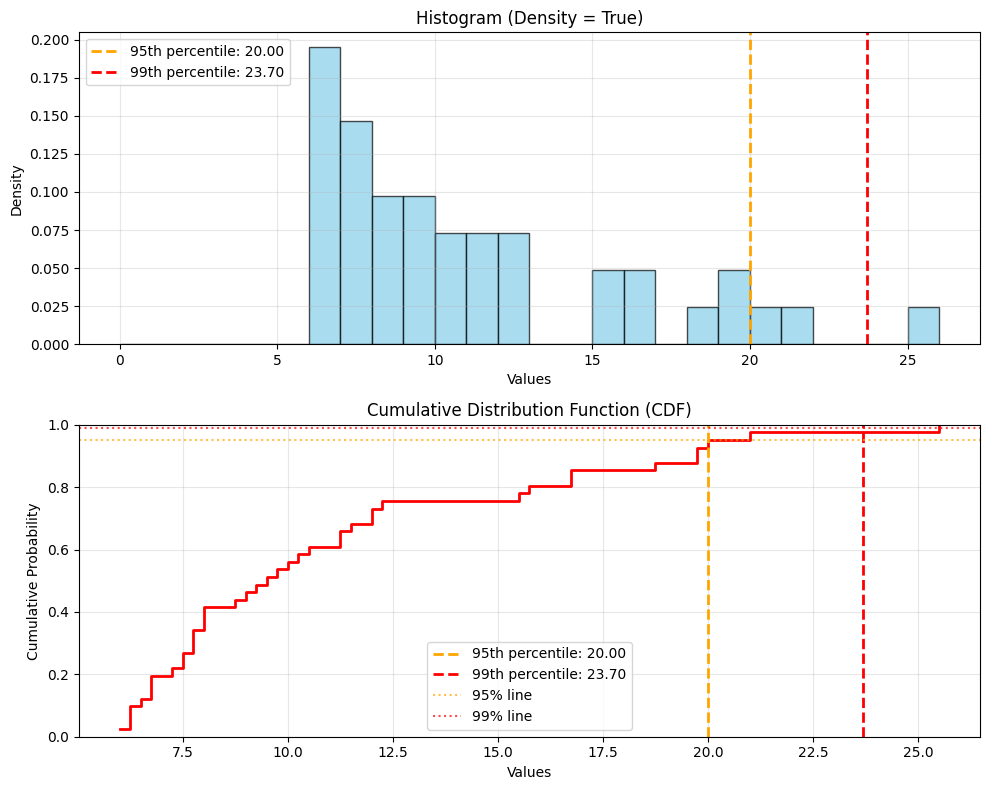

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy array for easier manipulation
data = np.array(rises)

# Calculate percentiles
percentile_95 = np.percentile(data, 95)
percentile_99 = np.percentile(data, 99)

print(f"95th percentile: {percentile_95}")
print(f"99th percentile: {percentile_99}")

# Define bins: starting from 0, with size 1
max_val = int(np.max(data))
bins = np.arange(0, max_val + 2, 1)  # 0, 1, 2, ..., max_val+1

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot histogram with density=True
ax1.hist(data, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(percentile_95, color='orange', linestyle='--', linewidth=2, label=f'95th percentile: {percentile_95:.2f}')
ax1.axvline(percentile_99, color='red', linestyle='--', linewidth=2, label=f'99th percentile: {percentile_99:.2f}')
ax1.set_xlabel('Values')
ax1.set_ylabel('Density')
ax1.set_title('Histogram (Density = True)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot CDF
sorted_data = np.sort(data)
y_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax2.step(sorted_data, y_values, where='post', linewidth=2, color='red')
ax2.axvline(percentile_95, color='orange', linestyle='--', linewidth=2, label=f'95th percentile: {percentile_95:.2f}')
ax2.axvline(percentile_99, color='red', linestyle='--', linewidth=2, label=f'99th percentile: {percentile_99:.2f}')
ax2.axhline(0.95, color='orange', linestyle=':', alpha=0.7, label='95% line')
ax2.axhline(0.99, color='red', linestyle=':', alpha=0.7, label='99% line')
ax2.set_xlabel('Values')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Cumulative Distribution Function (CDF)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()

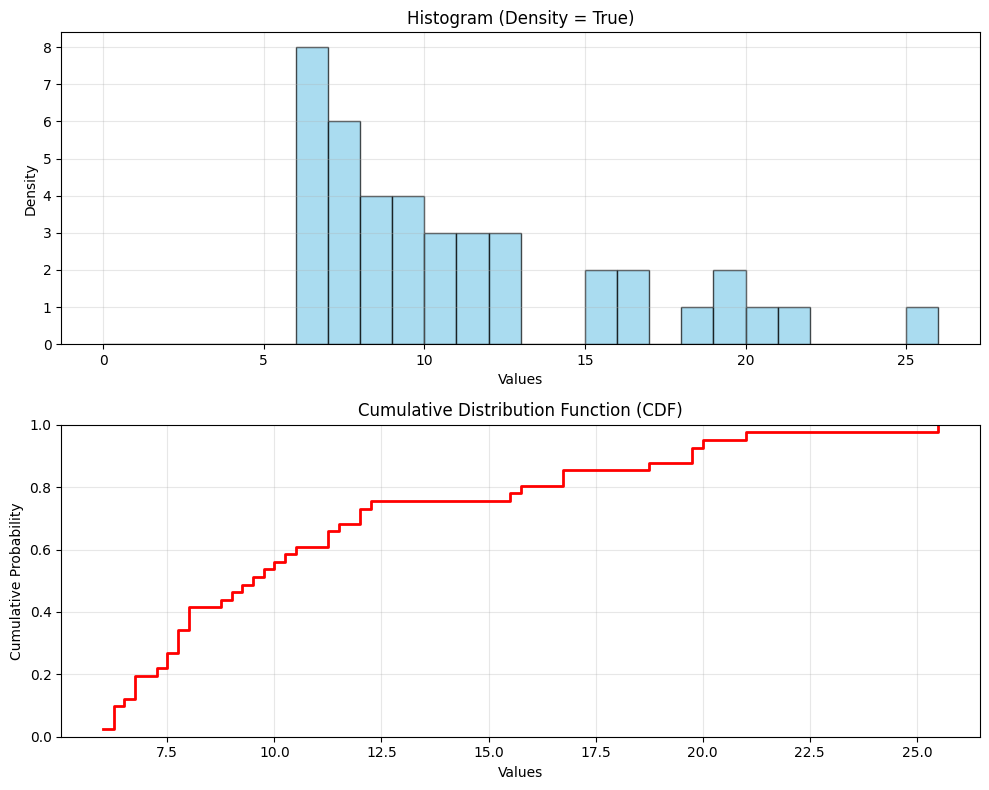

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Example list of numbers (replace with your actual data)

# Convert to numpy array for easier manipulation
data = np.array(rises)

# Define bins: starting from 0, with size 1
max_val = int(np.max(data))
bins = np.arange(0, max_val + 2, 1)  # 0, 1, 2, ..., max_val+1

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot histogram with density=True
ax1.hist(data, bins=bins, density=False, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Values')
ax1.set_ylabel('Density')
ax1.set_title('Histogram (Density = True)')
ax1.grid(True, alpha=0.3)

# Plot CDF
sorted_data = np.sort(data)
y_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax2.step(sorted_data, y_values, where='post', linewidth=2, color='red')
ax2.set_xlabel('Values')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Cumulative Distribution Function (CDF)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
import pickle
import pandas as pd
import numpy as np
from shared_functions import preprocess_data, dip_distribution_data_only
import os

def generate_dip_distributions(df1_path, df2_path):
    """Generate dip distributions from historical data"""
    print("Preprocessing data...")
    df, nan_ranges, cols_to_null = preprocess_data(df1_path, df2_path)

    print("Generating dip distributions...")
    distributions = {}

    # Ensure the output directory exists
    os.makedirs('distributions', exist_ok=True)

    for breakeven in [3, 4, 5]:
        breakeven_decimal = breakeven / 16

        print(f"Processing max_rise = {breakeven}/16...")
        dips_bps = dip_distribution_data_only(df, breakeven_decimal, breakeven_decimal, nan_ranges)

        if len(dips_bps) > 0:
            distributions[breakeven] = dips_bps
            print(f"  Found {len(dips_bps)} dips")

    return distributions, df, nan_ranges

def save_percentile_lookup_tables(distributions):
    """Save percentile lookup tables"""
    percentile_tables = {}

    for breakeven, dips_bps in distributions.items():
        sorted_dips = np.sort(dips_bps)
        percentiles = np.linspace(0, 100, len(sorted_dips))

        percentile_tables[breakeven] = {
            'dips': sorted_dips,
            'percentiles': percentiles,
            'stats': {
                'count': len(dips_bps),
                'mean': np.mean(dips_bps),
                'p95': np.percentile(dips_bps, 95),
                'p99': np.percentile(dips_bps, 99)
            }
        }

    with open('distributions/percentile_tables.pkl', 'wb') as f:
        pickle.dump(percentile_tables, f)

    print("Percentile tables saved!")
    return percentile_tables

def main():
    # Your file paths
    df1_path = 'ZN_1h_events_tagged_target_tz_nonevents.csv'
    df2_path = 'Intraday_data_ZN_1h_2022-12-20_to_2025-06-11.csv'

    distributions, df, nan_ranges = generate_dip_distributions(df1_path, df2_path)
    percentile_tables = save_percentile_lookup_tables(distributions)

if __name__ == "__main__":